In [5]:
import pickle

import numpy as np
import heartpy as hp

from enum import IntEnum
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
class Labels(IntEnum):
    BASELINE = 1
    STRESS = 2
    AMUSEMENT = 3
    MEDITATION = 4

In [3]:
subjects_ecg_signals = {}

In [4]:
wesad = Path()
for subject in tqdm(wesad.glob("S*")):
    with open((subject / subject).with_suffix(".pkl"), "rb") as f:
        subject_id = int(subject.name[1:])
        data = pickle.load(f, encoding="latin1")
        subjects_ecg_signals[subject_id] = {
            "ecg": data.get("signal").get("chest").get("ECG").squeeze(),
            "ecg_labels": data.get("label"),
        }

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
# duration (minutes)
sorted(
    [
        (i, round(data.get("ecg").shape[0] / 700 / 60, 3))
        for i, data in subjects_ecg_signals.items()
    ]
)

In [ ]:
np.unique(
    subjects_ecg_signals.get(2).get("ecg_labels"),
    return_counts=True,
    return_index=True,
)

In [ ]:
fig, ax = plt.subplots(
    len(subjects_ecg_signals), 2, figsize=(20, 3 * len(subjects_ecg_signals))
)
for i, (subject_id, data) in tqdm(
    enumerate(sorted(subjects_ecg_signals.items()))
):
    print(subject_id)
    ax[i, 0].plot(
        (
            subjects_ecg_signals.get(subject_id).get("ecg_labels")
            == Labels.BASELINE
        ).astype(int)
    )
    ax[i, 0].set_title(f"Subject {subject_id}; Baseline")
    ax[i, 1].plot(
        (
            subjects_ecg_signals.get(subject_id).get("ecg_labels")
            == Labels.STRESS
        ).astype(int)
    )
    ax[i, 1].set_title(f"Subject {subject_id}; Stress")
plt.tight_layout()

In [ ]:
# проверяем, что только по одному промежутку в состоянии покоя (начальном) и стресса
for subject_id, data in tqdm(subjects_ecg_signals.items()):
    indices = np.where(data.get("ecg_labels") == Labels.BASELINE)
    single_baseline = (indices[0][-1] + 1 - indices[0][0]) == (
        data.get("ecg_labels") == Labels.BASELINE
    ).sum()
    indices = np.where(data.get("ecg_labels") == Labels.STRESS)
    single_stress = (indices[0][-1] + 1 - indices[0][0]) == (
        data.get("ecg_labels") == Labels.STRESS
    ).sum()
    if not single_baseline or not single_stress:
        print(
            f"Subject {subject_id} has more than 1 period of baseline and stress"
        )

In [ ]:
subjects_baseline_and_stress = {}
rate = 700
for subject_id, data in tqdm(subjects_ecg_signals.items()):
    subject_data = []
    for label in [Labels.BASELINE, Labels.STRESS]:
        signal = data.get("ecg")[data.get("ecg_labels") == label]
        wd, m = hp.process(signal, rate)
        subject_data.append(
            {
                "label": label,
                "signal": signal,
                "working_data": wd,
                "measurements": m,
            }
        )
    subjects_baseline_and_stress[subject_id] = subject_data

In [ ]:
with open("wesad_computed.pkl", "wb") as out:
    pickle.dump(subjects_baseline_and_stress, out)

In [ ]:
# RR intervals distribution
fix, ax = plt.subplots(
    len(subjects_baseline_and_stress),
    2,
    figsize=(10, 4 * len(subjects_baseline_and_stress)),
)
for i, (s_id, data) in enumerate(sorted(subjects_baseline_and_stress.items())):
    for j, labeled_data in enumerate(data):
        rr_corr_arr = np.array(
            labeled_data.get("working_data").get("RR_list_cor")
        )
        ax[i, j].hist(
            rr_corr_arr, bins=15, range=(rr_corr_arr.min(), rr_corr_arr.max())
        )
        ax[i, j].set(
            title=f"Subject {s_id} {Labels(labeled_data.get('label')).name}"
        )
plt.show()

In [ ]:
d = subjects_baseline_and_stress.get(2)[0]
hp.plotter(d.get("working_data"), d.get("measurements"), figsize=(200, 9))
plt.savefig("out.png")

In [ ]:
len(d.get("working_data").get("RR_list_cor"))

---

In [1]:
import pickle

import numpy as np

In [2]:
with open("wesad_computed.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
print("id\t|\t    stress\t\t ||\t\t  baseline")
print("\t|  mean   |    std   ||   mean   |  std   ")
for subj, vals in sorted(data.items()):
    stress, baseline = (
        vals if vals[0].get("label") == Labels.STRESS else vals[1],
        vals[0],
    )
    stress_data = stress.get("working_data").get("RR_list_cor")
    baseline_data = baseline.get("working_data").get("RR_list_cor")
    s_mean, s_std = np.mean(stress_data), np.std(stress_data)
    b_mean, b_std = np.mean(baseline_data), np.std(baseline_data)
    print(
        f"{subj:2d}\t|{s_mean:8.3f} | {s_std:8.3f} || {b_mean:8.3f} | {b_std:8.3f}"
    )

id	|	    stress		 ||		  baseline
	|  mean   |    std   ||   mean   |  std   


NameError: name 'Labels' is not defined

---
## Lightweight

In [ ]:
import pickle

import numpy as np

In [ ]:
with open("wesad_computed.pkl", "rb") as f:
    data = pickle.load(f)

In [ ]:
rr_intervals = {
    subject: [
        {
            "label": subj_state.get("label"),
            "signal": subj_state.get("signal"),
            "rr_intervals": np.array(
                subj_state.get("working_data").get("RR_list_cor")
            ),
        }
        for subj_state in subj_data
    ]
    for subject, subj_data in data.items()
}

In [ ]:
with open("wesad_signal_and_rr_intervals.pkl", "wb") as out:
    pickle.dump(rr_intervals, out)

## Boxplot

In [4]:
import math
import pickle
from matplotlib import pyplot as plt

In [5]:
with open("wesad_signal_and_rr_intervals.pkl", "rb") as in_:
    rr_intervals_non_normalised = pickle.load(in_)

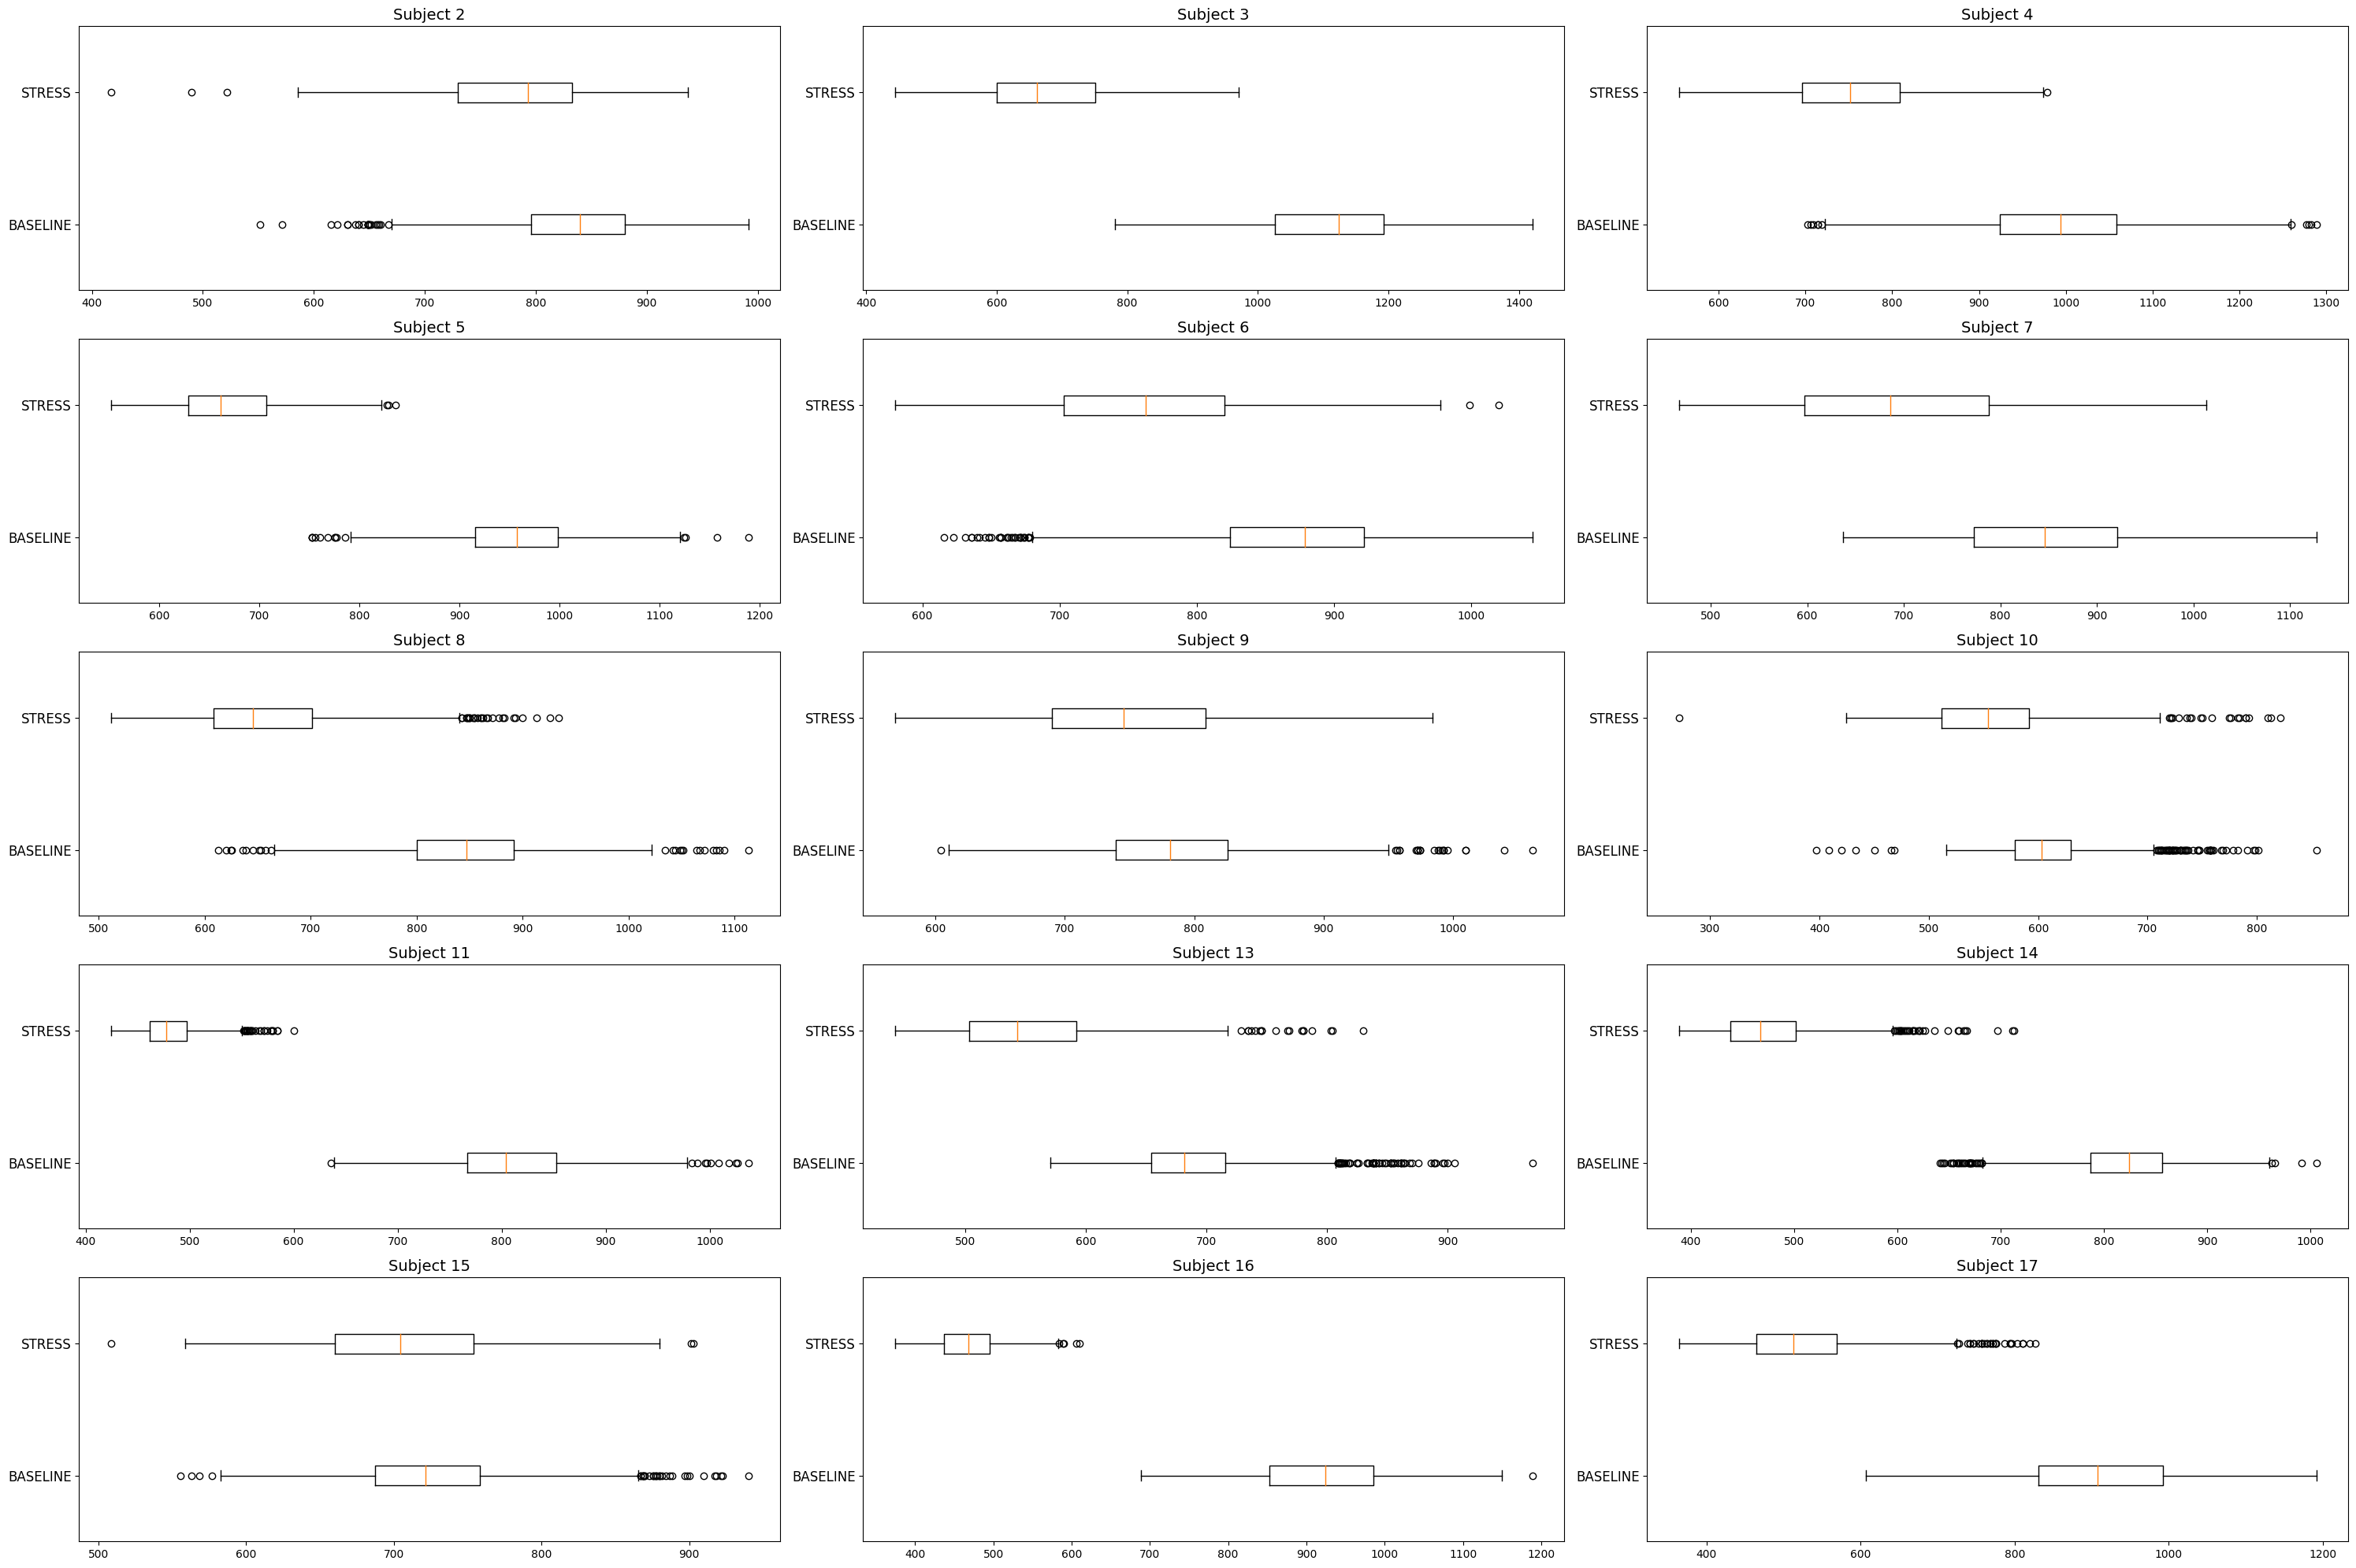

In [6]:
fix, axes = plt.subplots(
    math.ceil(len(rr_intervals_non_normalised) / 3), 3, figsize=(30, 20)
)
for i, (subj, data) in enumerate(sorted(rr_intervals_non_normalised.items())):
    labels = list(map(lambda x: str(x.get("label")).split(".")[1], data))
    signals = list(map(lambda x: x.get("rr_intervals"), data))
    ax = axes[int(i / 3), i % 3]
    ax.boxplot(signals, vert=0)
    ax.set_yticklabels(labels, fontdict={"fontsize": 12})
    ax.set_title(f"Subject {subj}", fontdict={"fontsize": 14})
plt.tight_layout()

In [40]:
mapping_non_normalised = {
    f"subj_{subj}_{str(state.get('label')).split('.')[1]}": state.get(
        "rr_intervals"
    )
    for subj, data in rr_intervals_non_normalised.items()
    for state in data
}

In [41]:
labels, data_non_normalised = zip(
    *sorted(
        mapping_non_normalised.items(), key=lambda x: int(x[0].split("_")[1])
    )
)

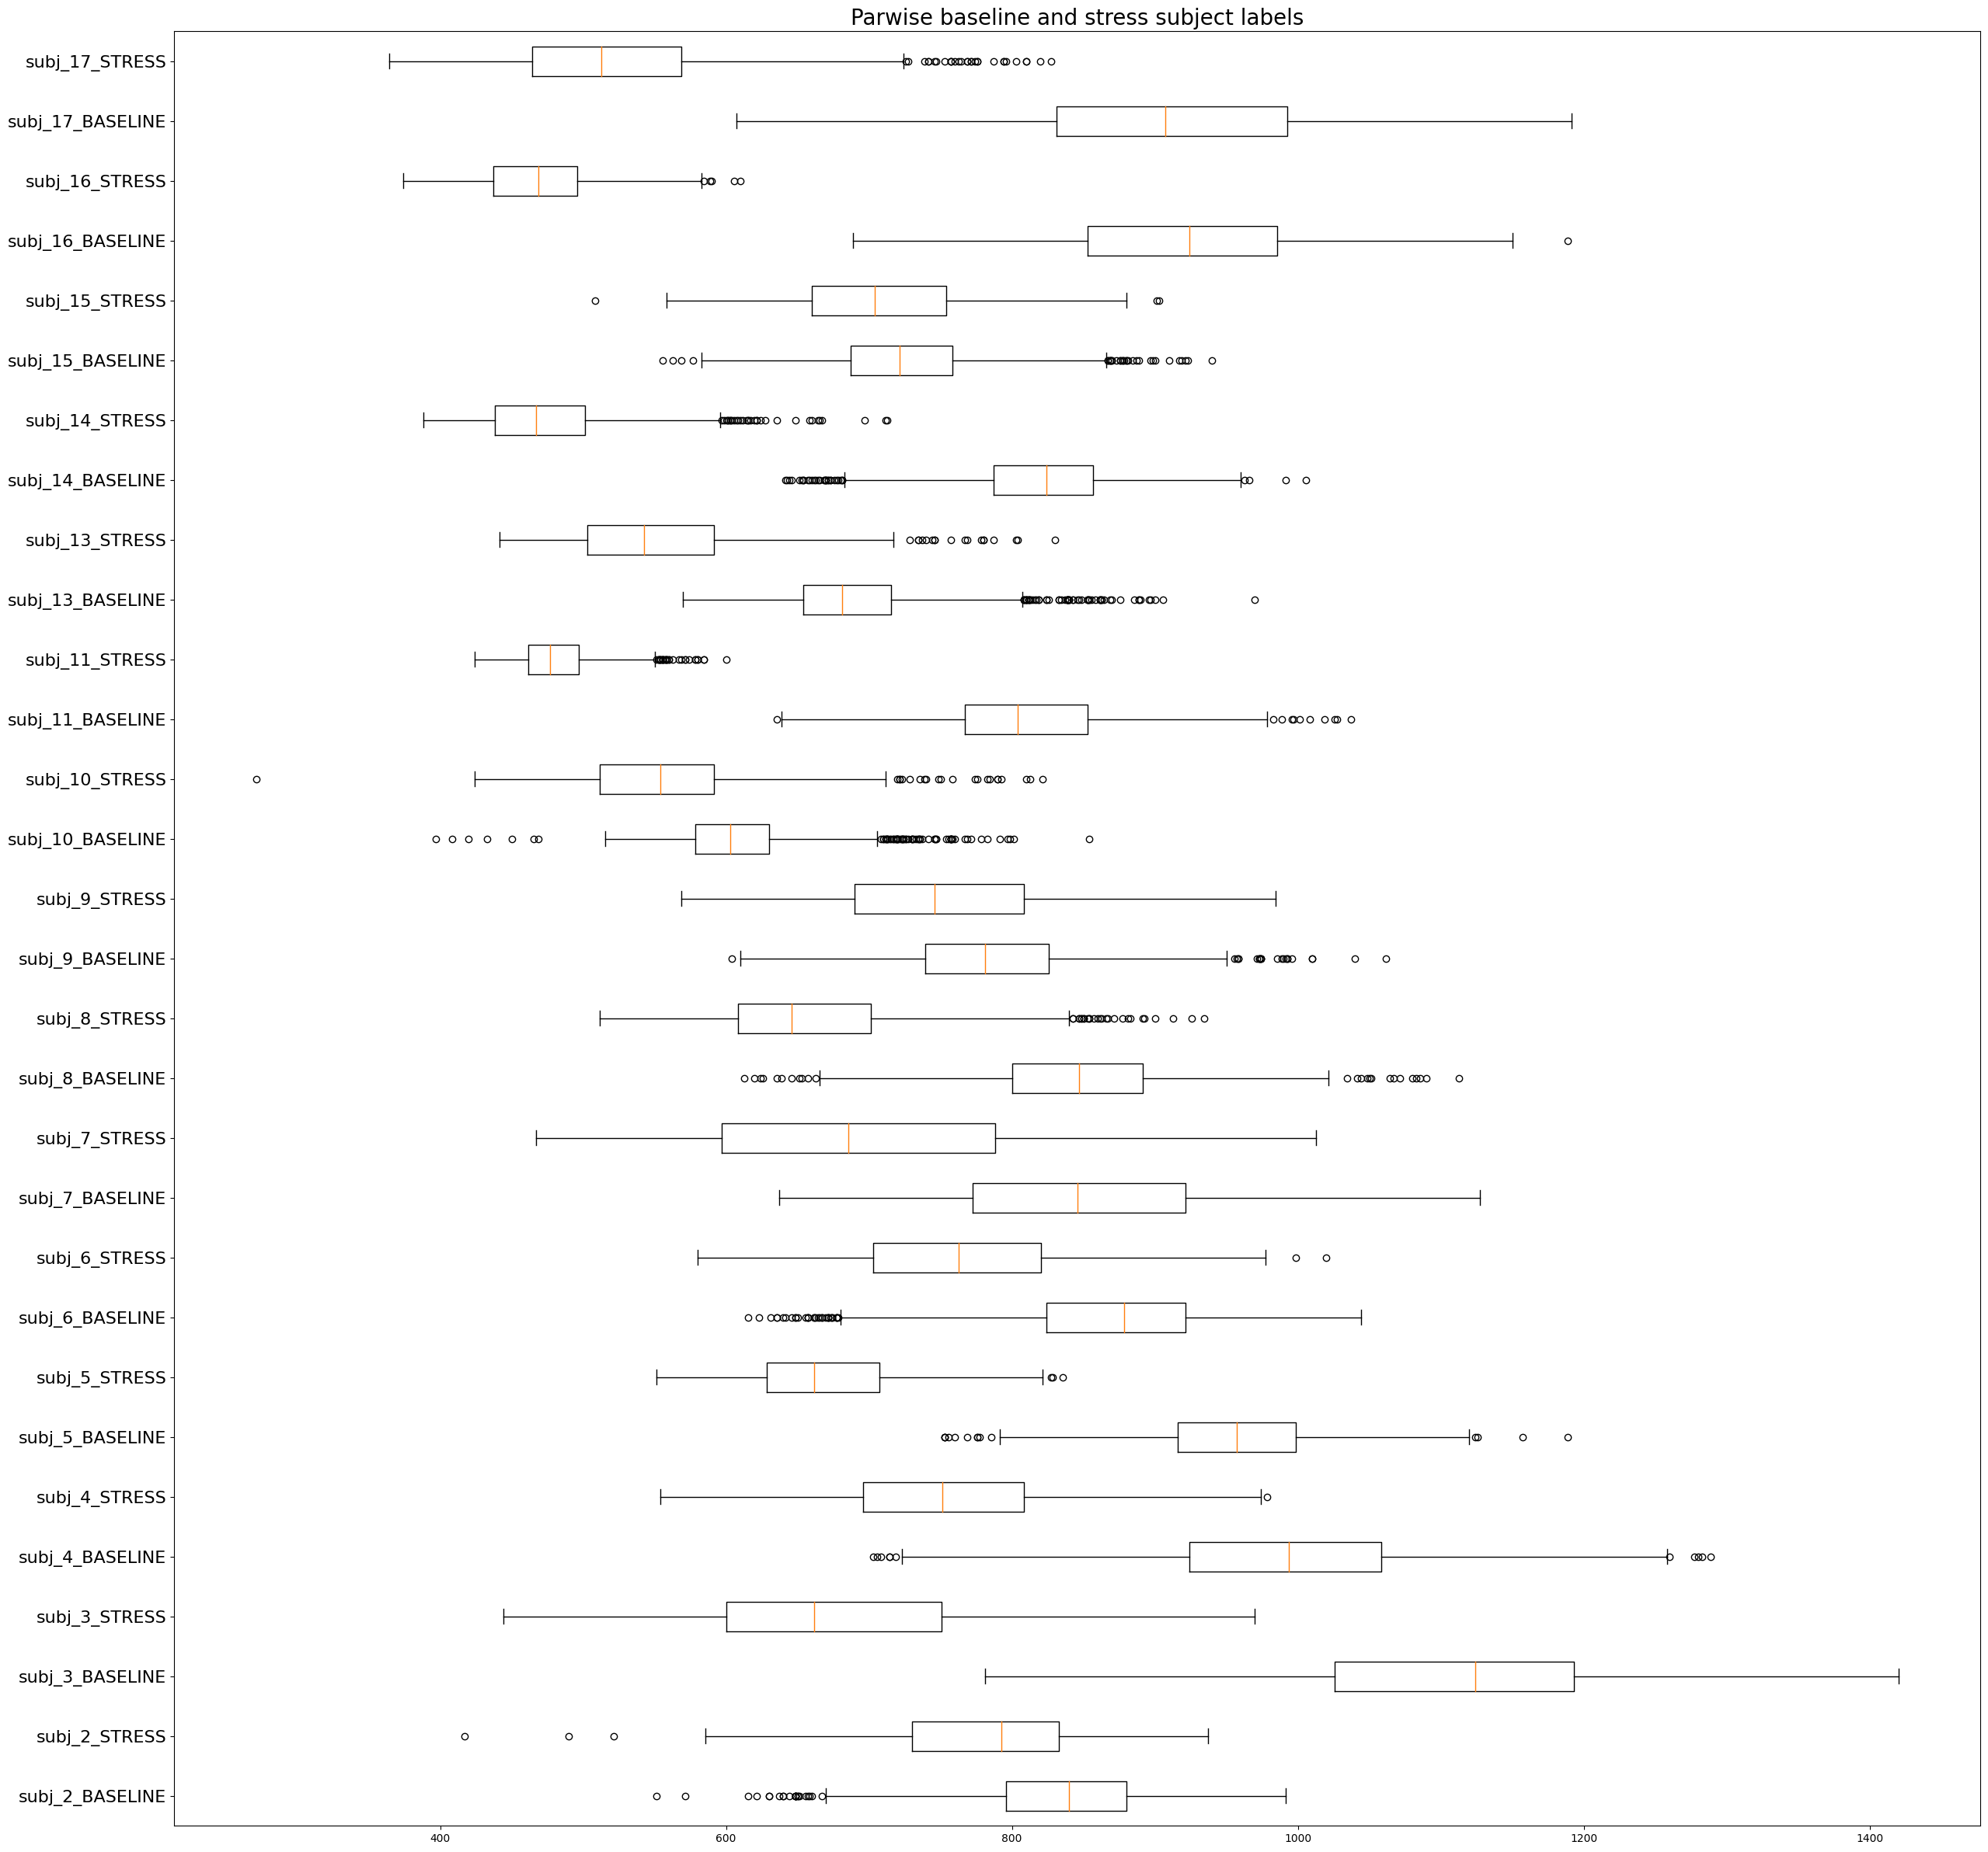

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
ax.boxplot(data_non_normalised, vert=0)
ax.set_yticklabels(labels, fontdict={"fontsize": 16})
ax.set_title(
    "Parwise baseline and stress subject labels", fontdict={"fontsize": 20}
)
pass

In [71]:
def order(x):
    subj, label = x[0].split("_")[1:]
    return label, int(subj)


labels_group_label, data_non_normalised_group_label = zip(
    *sorted(mapping_non_normalised.items(), key=order)
)

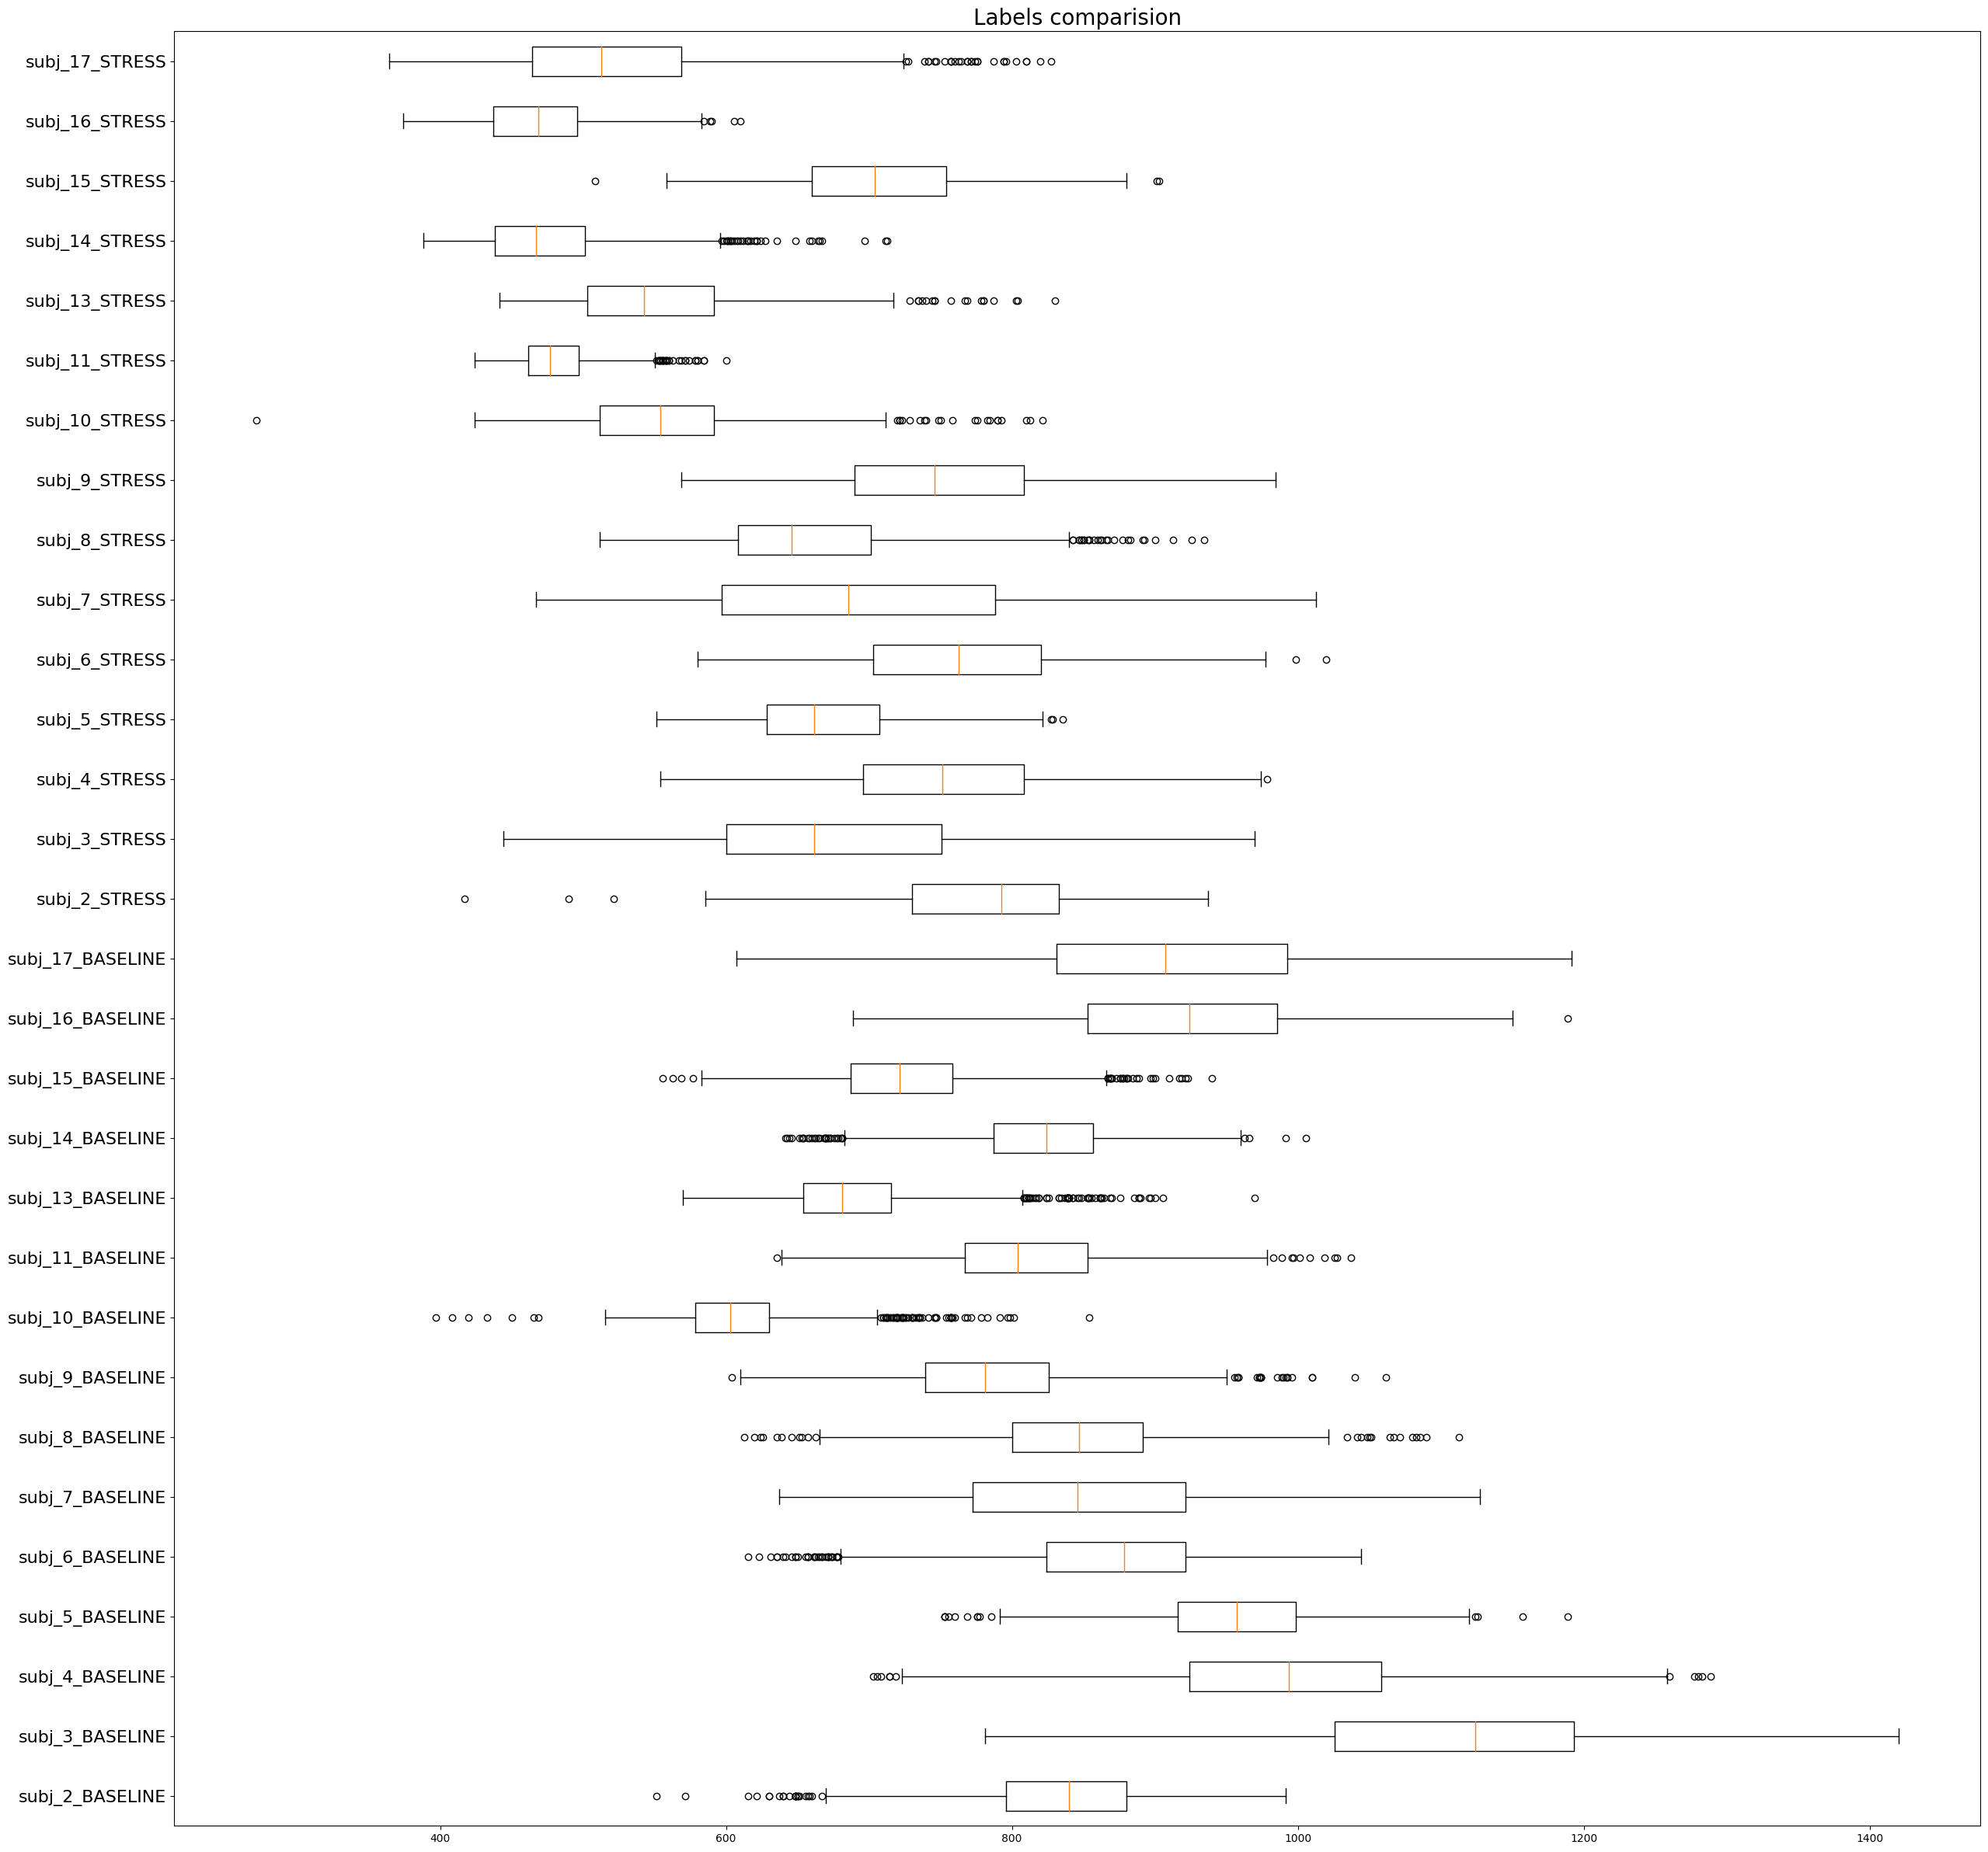

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
ax.boxplot(data_non_normalised_group_label, vert=0)
ax.set_yticklabels(labels_group_label, fontdict={"fontsize": 16})
ax.set_title("Labels comparision", fontdict={"fontsize": 20})
pass
# 2, 9, 3, 5

In [53]:
labels_stress, stress_data_non_normalised = zip(
    *sorted(
        filter(
            lambda x: x[0].endswith("STRESS"), mapping_non_normalised.items()
        ),
        key=lambda x: int(x[0].split("_")[1]),
    )
)
labels_stress = map(lambda x: x.replace("_STRESS", ""), labels_stress)

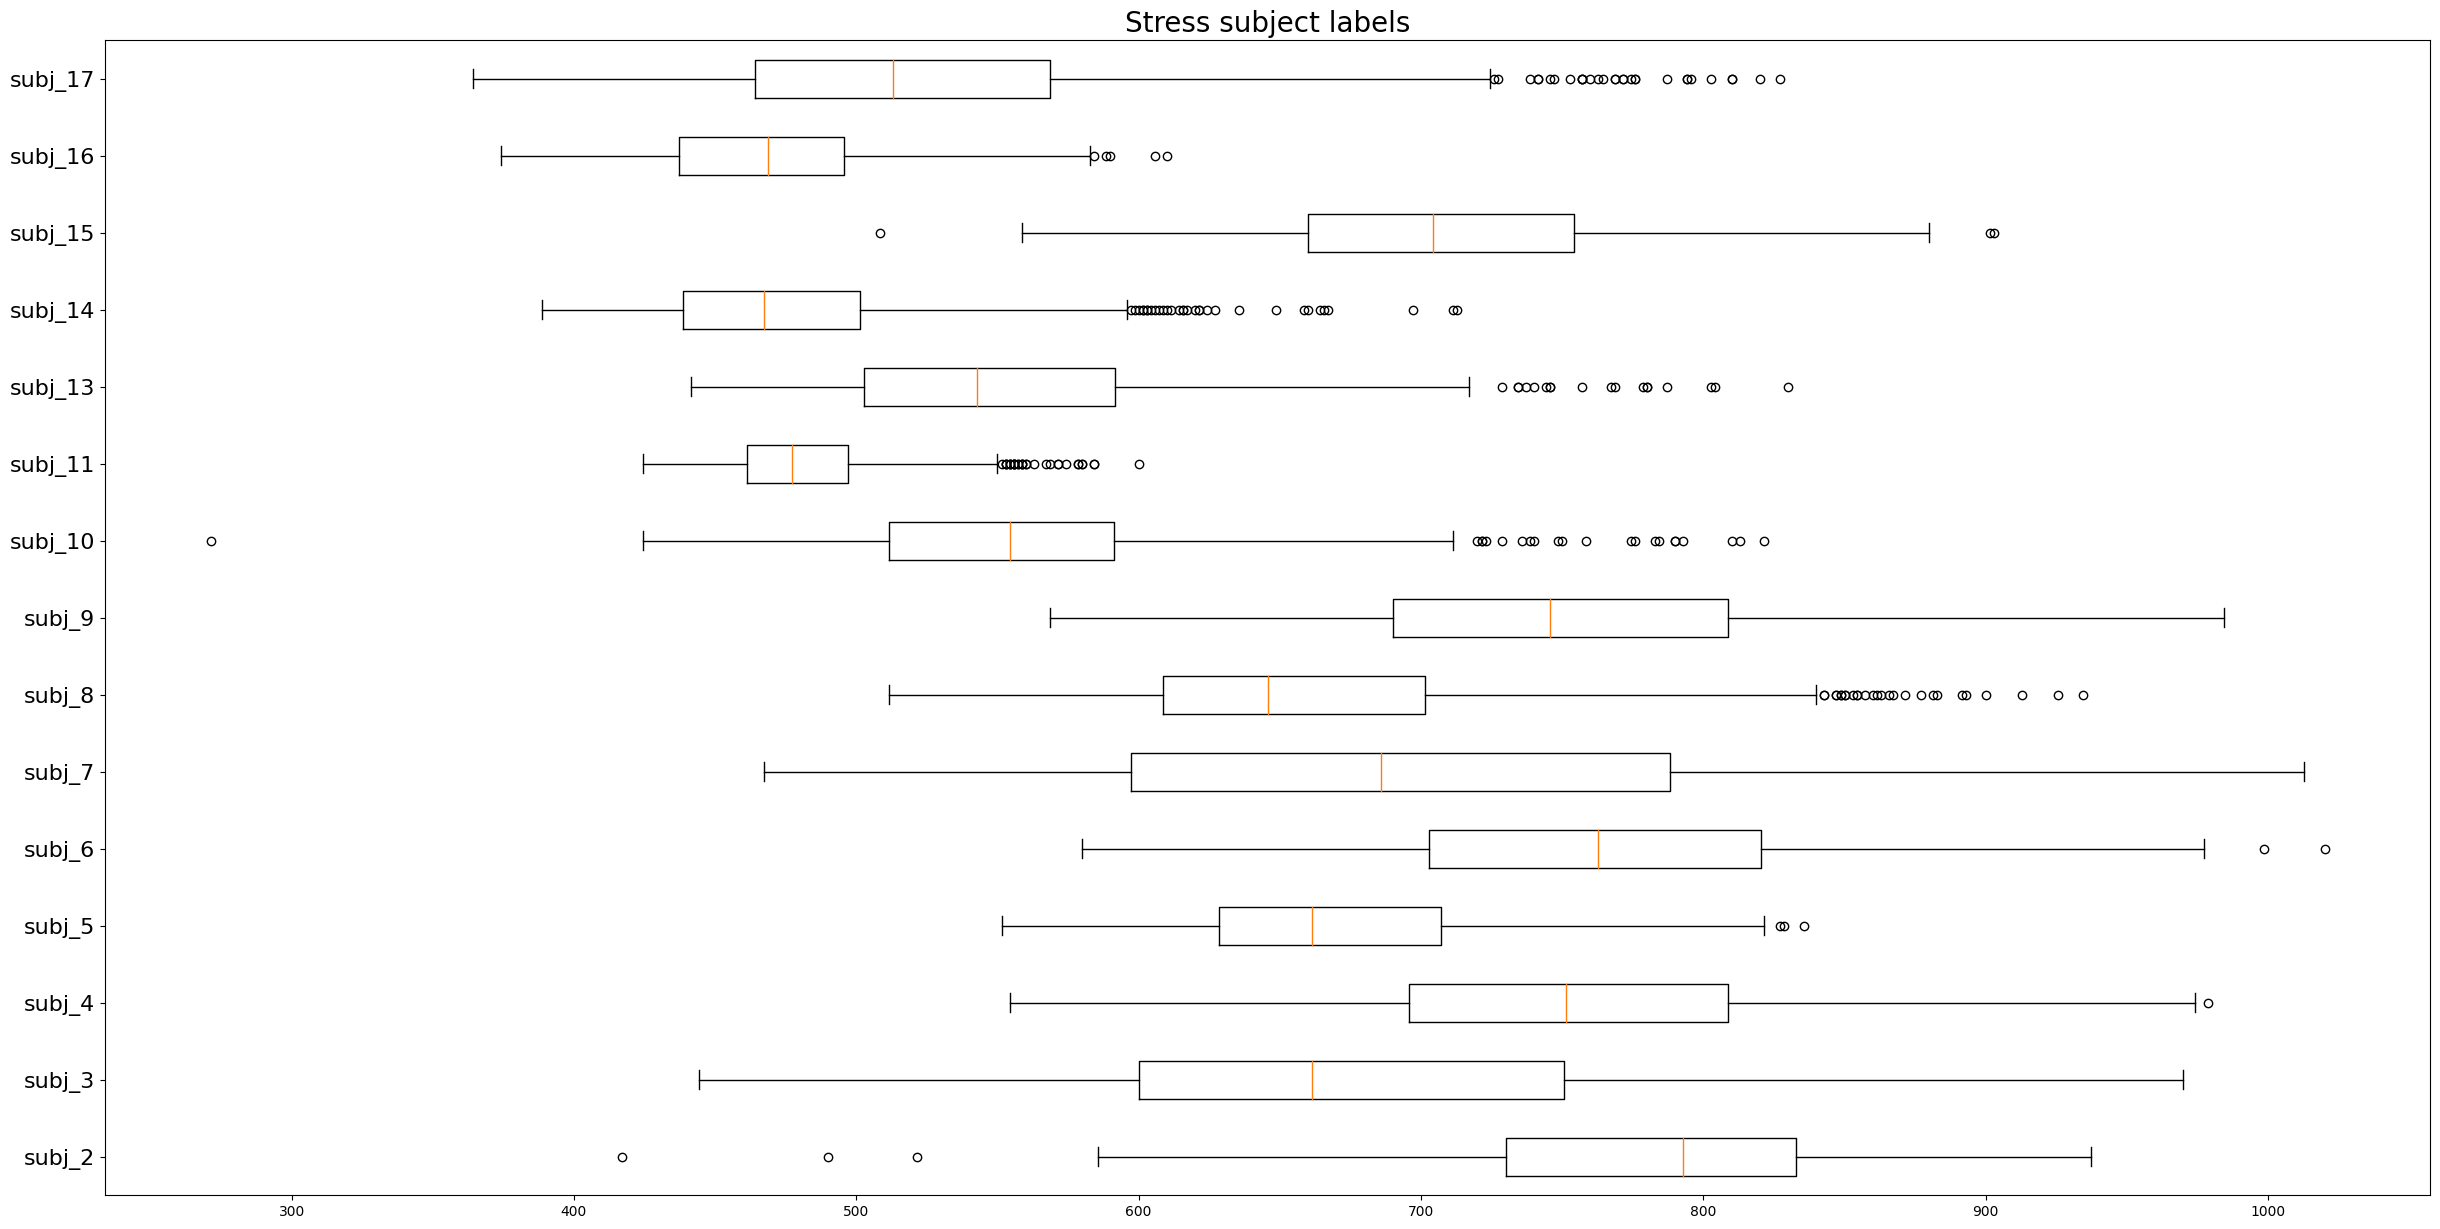

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.boxplot(stress_data_non_normalised, vert=0)
ax.set_yticklabels(labels_stress, fontdict={"fontsize": 16})
ax.set_title("Stress subject labels", fontdict={"fontsize": 20})
pass

In [68]:
labels_baseline, baseline_data_non_normalised = zip(
    *sorted(
        filter(
            lambda x: x[0].endswith("BASELINE"), mapping_non_normalised.items()
        ),
        key=lambda x: int(x[0].split("_")[1]),
    )
)
labels_baseline = map(lambda x: x.replace("_BASELINE", ""), labels_baseline)

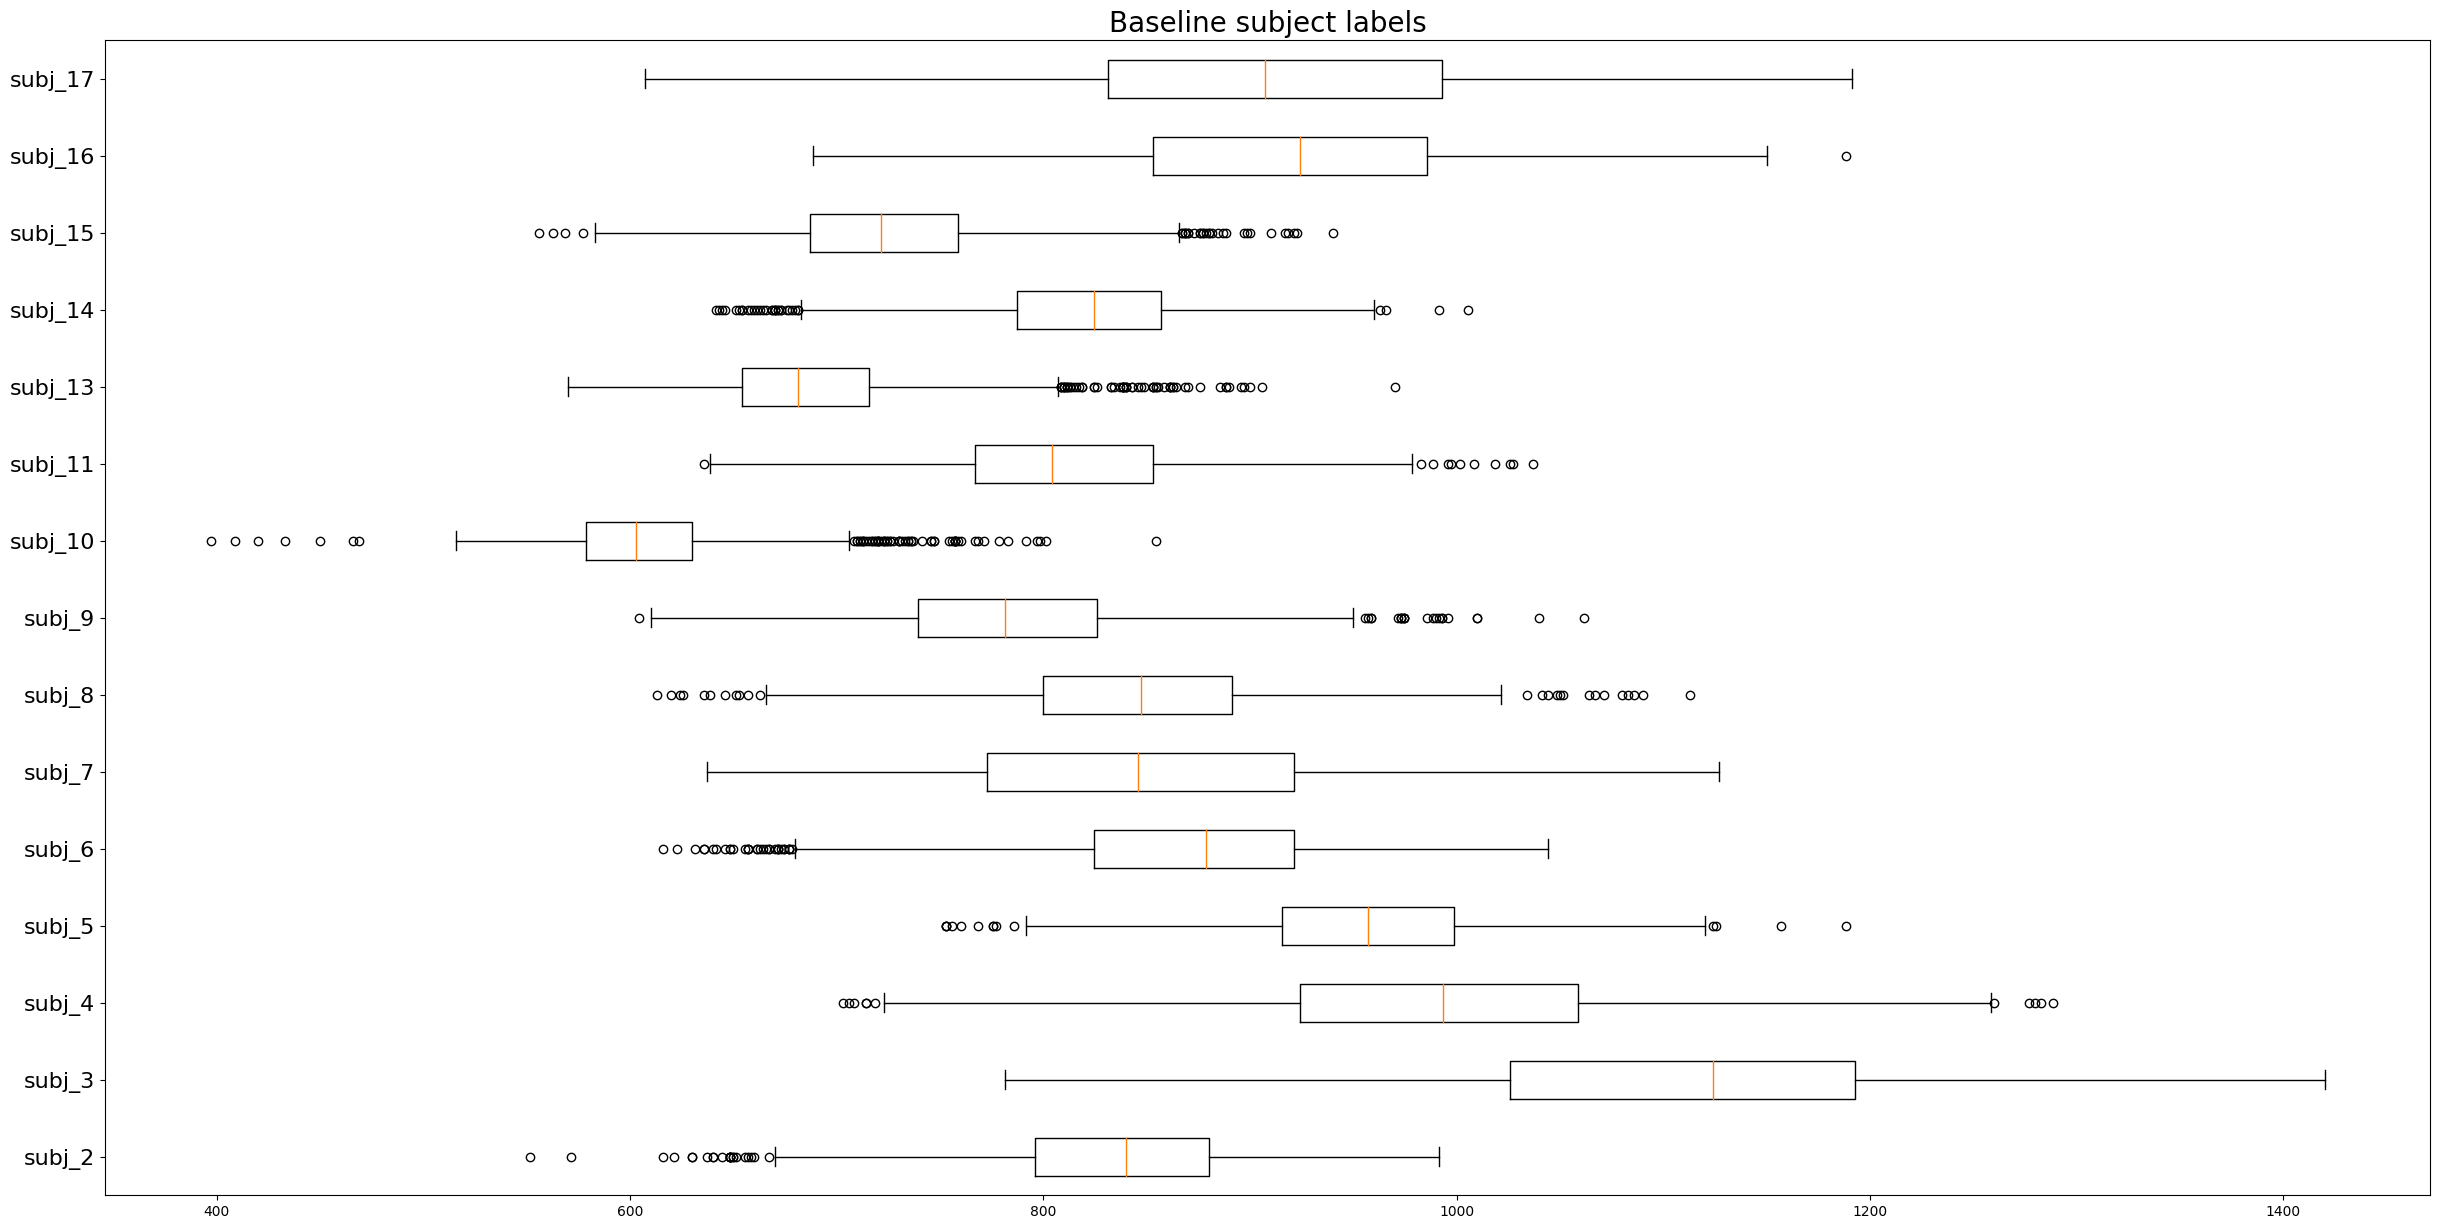

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.boxplot(baseline_data_non_normalised, vert=0)
ax.set_yticklabels(labels_baseline, fontdict={"fontsize": 16})
ax.set_title("Baseline subject labels", fontdict={"fontsize": 20})
pass

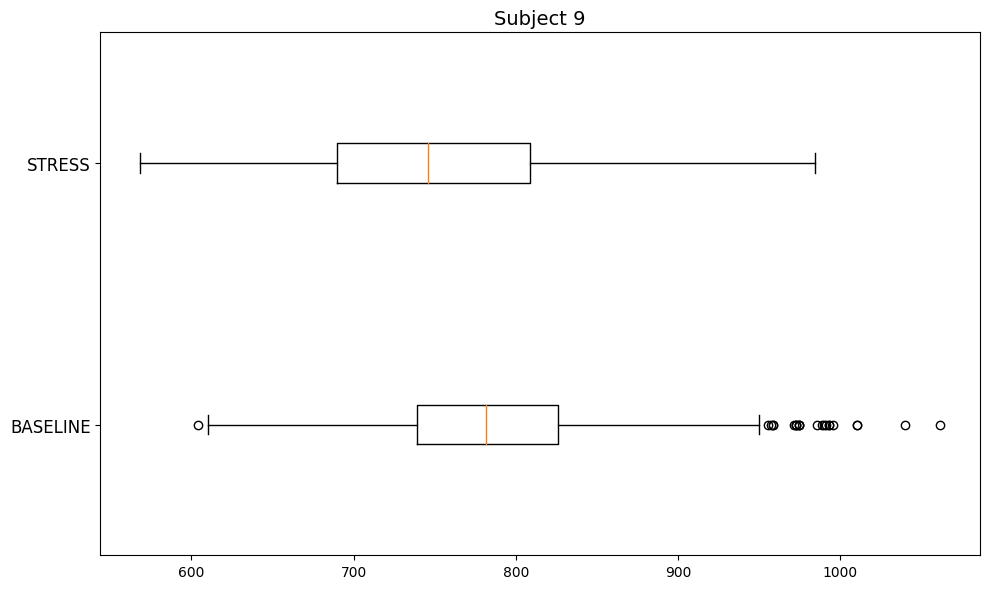

In [9]:
fix, axes = plt.subplots(1,1, figsize=(10, 6))
data = rr_intervals_non_normalised.get(9)
labels = list(map(lambda x: str(x.get("label")).split(".")[1], data))
signals = list(map(lambda x: x.get("rr_intervals"), data))
ax = axes
ax.boxplot(signals, vert=0)
ax.set_yticklabels(labels, fontdict={"fontsize": 12})
ax.set_title(f"Subject 9", fontdict={"fontsize": 14})
plt.tight_layout()

---
## Standard normalisation

In [ ]:
import pickle
from itertools import chain
from sklearn.preprocessing import StandardScaler

In [ ]:
with open("wesad_signal_and_rr_intervals.pkl", "rb") as f:
    rr_intervals = pickle.load(f)

In [ ]:
for subject, data in rr_intervals.items():
    scaler = StandardScaler()
    full = np.fromiter(
        chain.from_iterable(map(lambda x: x.get("rr_intervals"), data)),
        dtype=float,
    )
    scaler.fit(full.reshape((-1, 1)))
    for state in data:
        state.update(
            {
                "rr_intervals_subject_normalised": np.ravel(
                    scaler.transform(
                        state.get("rr_intervals").reshape((-1, 1)),
                        copy=True,
                    )
                )
            }
        )

In [ ]:
with open("wesad_signal_and_normalised_rr_intervals.pkl", "wb") as out:
    pickle.dump(rr_intervals, out)

## Normalised boxplot

In [27]:
import pickle
from matplotlib import pyplot as plt

In [44]:
with open("wesad_signal_and_normalised_rr_intervals.pkl", "rb") as in_:
    rr_intervals_normalised = pickle.load(in_)

In [45]:
mapping_normalised = {
    f"subj_{subj}_{str(state.get('label')).split('.')[1]}": state.get(
        "rr_intervals_subject_normalised"
    )
    for subj, data in rr_intervals_normalised.items()
    for state in data
}

In [46]:
labels, data_normalised = zip(
    *sorted(mapping_normalised.items(), key=lambda x: int(x[0].split("_")[1]))
)

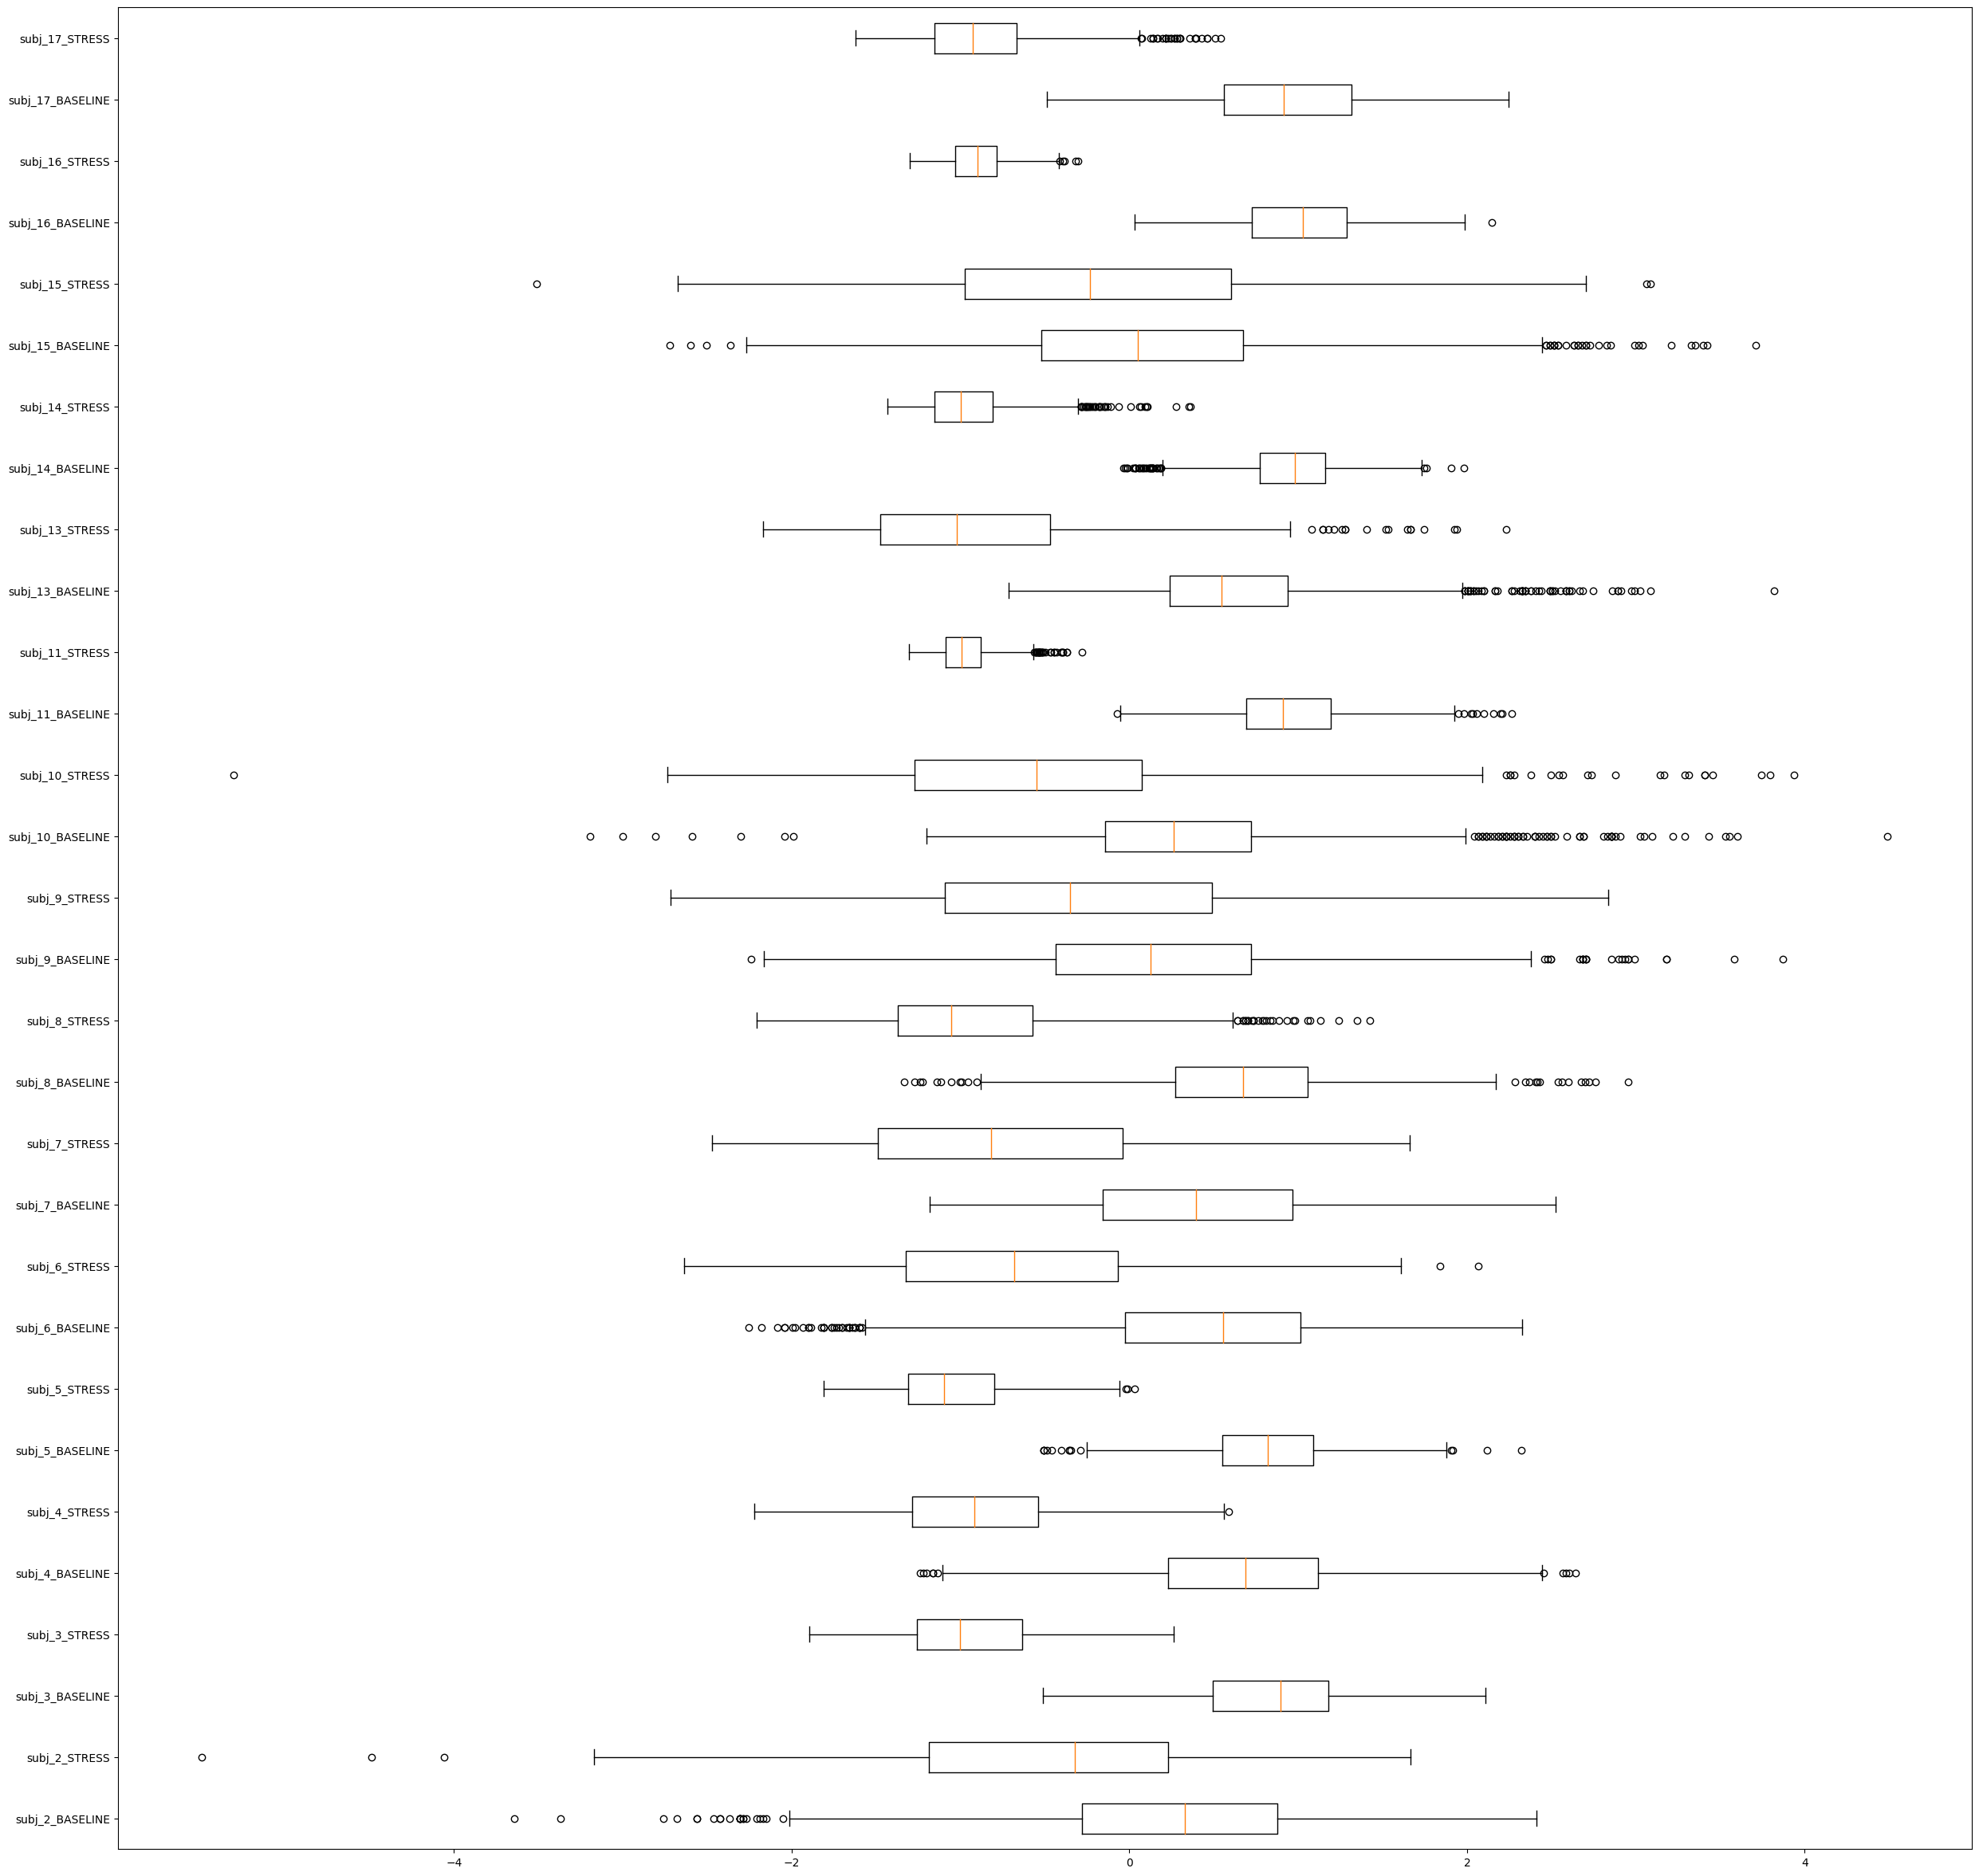

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
ax.boxplot(data_normalised, vert=0)
ax.set_yticklabels(labels)
pass